In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import xgboost as xgb 
from sklearn.model_selection import TimeSeriesSplit
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)
from sklearn.model_selection import cross_val_score
import seaborn as sns
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=2)

In [533]:
train = pd.read_csv('train.csv', parse_dates=['Дата транзакции'])
test = pd.read_csv('example.csv', parse_dates=['Дата транзакции'])
tariff = pd.read_csv('Тарифы 2019-2020.csv')  #БЕ №5
contragent = pd.read_csv('Контрагенты по годам.csv') #БЕ №5
ora = pd.read_csv('Покупка с ОРЭ 2019-2020.csv')#БЕ №3
valid_res = pd.read_excel('1кв2021_1.xlsx')

In [208]:
tariff.drop(tariff.columns[0], axis=1, inplace=True)
tariff=tariff.rename(columns={tariff.columns[5]:"sum",
                              tariff.columns[4]:"tariff",
                              tariff.columns[0]:"ctr",
                              tariff.columns[1]:'mth',
                              tariff.columns[2]:'year'})


tariff['sum'] = tariff['sum'].apply(lambda x: x.replace(' ',""))

tariff['sum'] = tariff['sum'].apply(lambda x: x.replace(',',"."))

tariff['sum'] = tariff['sum'].astype(float)

In [225]:
tariff_1 = tariff.loc[tariff['ctr']==1]
tariff_2 = tariff.loc[tariff['ctr']==2]
tariff_3 = tariff.loc[tariff['ctr']==3]
tariff_4 = tariff.loc[tariff['ctr']==4]

In [534]:
# приведем к нужному временному формату дату
for i in range(valid_res.shape[0]):
    date=valid_res.iloc[i,2]
    date = date.replace('.','')
    revdate = date[4:]+'-'+date[2:4]+'-'+date[0:2]
    valid_res.iloc[i,2]=revdate

In [4]:
# выкидываем маленькие выплаты
zero_inedx = []
for i in range(train.shape[0]):
    if train.iloc[i,2] > -150000:
        zero_inedx.append(i)
train.drop(train.index[zero_inedx], inplace=True)

In [5]:
# могли получиться положительные значения - занулим их
def PosToZero(dfres):
    for i in range(dfres.shape[0]):
        if dfres.iloc[i,1] > 0:
            dfres.iloc[i,1] = 0

In [6]:
def AlignData(be):
    startIdx = 0
    train_part = train[train['БЕ']==be]
    train_part.drop(['БЕ'], axis=1, inplace=True)
    train_align = pd.DataFrame(columns=['Дата транзакции', 'Сумма в RUB'])
    prev = train_part.iloc[startIdx,0]
    train_align=train_align.append(train_part.iloc[0])
    ind = 1; indAlign = 1
    while ind < train_part.shape[0]:
        # ниже мы рассматриваем разницу в днях 
        if train_part.iloc[ind,0] - prev == timedelta(days=7):
            prev = train_part.iloc[ind,0]
            train_align = train_align.append(train_part.iloc[ind])
            ind += 1; indAlign += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=8):
            train_part.iloc[ind,0]=prev+timedelta(days=7)
            prev = train_part.iloc[ind,0]
            train_align = train_align.append(train_part.iloc[ind])
            ind += 1; indAlign += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=4):
            train_part.iloc[ind,0]=prev+timedelta(days=7)
            prev = train_part.iloc[ind,0]
            train_align = train_align.append(train_part.iloc[ind])
            ind += 1; indAlign += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=9):
            train_part.iloc[ind,0]=prev+timedelta(days=7)
            prev=train_part.iloc[ind,0]
            train_align = train_align.append(train_part.iloc[ind])
            ind += 1; indAlign += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=6):
            train_part.iloc[ind,0]=prev+timedelta(days=7)
            prev=train_part.iloc[ind,0]
            train_align = train_align.append(train_part.iloc[ind])
            ind += 1; indAlign += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=5):
            train_part.iloc[ind,0]=prev+timedelta(days=7)
            prev=train_part.iloc[ind,0]
            train_align = train_align.append(train_part.iloc[ind])
            ind += 1; indAlign += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=1):#for bu=2
            train_align.iloc[indAlign-1,1] += train_part.iloc[ind,1] 
            ind += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=2):#for bu=2
            train_align.iloc[indAlign-1,1] += train_part.iloc[ind,1] 
            ind += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=0):
            train_align.iloc[indAlign-1,1] += train_part.iloc[ind,1] 
            ind += 1
        # change
        elif train_part.iloc[ind,0] - prev < timedelta(days=0):
            ind += 1
        else :
            train_align=train_align.append(pd.DataFrame([[prev+timedelta(days=7), 0]], columns=['Дата транзакции', 'Сумма в RUB']), ignore_index=True)
            prev=prev+timedelta(days=7)
            indAlign += 1
    train_align = train_align.set_index('Дата транзакции')
    return train_align

In [7]:
class ARModel:
    def __init__(self, window, model):
        self.window = window
        self.model = model
    
    def fit(self, path):
        n = path.strides[0]
        X = np.lib.stride_tricks.as_strided(
            path,
            shape=(path.shape[0], self.window),
            strides=(n, n),
        )[:-self.window]
        Y = path[self.window:]
        self.history = path[-self.window:].reshape(1, -1)
        self.model.fit(X, Y)
        
    def forecast(self, steps):
        history = self.history.copy()
        predictions = np.empty(steps)
        
        for i in range(steps):
            y_pred = self.model.predict(history)[0]    
            predictions[i] = y_pred
            
            history[0, :-1] = history[0, 1:]
            history[0, -1] = y_pred

        return predictions

In [8]:
#Ниже функция осуществляет предобработку данных - добавляет лаги.
#Также она делит выборку на тренировочную и тестовую, чтобы определить ошибку и сравнить графически.
def prepareData(data, lag_start=1, lag_end=10,test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, y_train, X_test, y_test

In [9]:
# функция для построения графика
def plotCoefficients(model, X_train):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [10]:
# функция, которая предсказывает значения модели и строит график
def plotModelResults(model, X_train, X_test,y_test,y_train, plot_intervals=False, plot_anomalies=False, scale=1.96, y_pred=[], plot=True):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    error = mean_absolute_error(prediction, y_test)
    prediction = np.append(prediction, y_pred)
    if plot:
        plt.figure(figsize=(15, 7))
        plt.plot(prediction, "g", label="prediction", linewidth=2.0)
        plt.plot(y_test.values, label="actual", linewidth=2.0)
        if plot_intervals:
            cv = cross_val_score(model, X_train, y_train, 
                                        cv=tscv, 
                                        scoring="neg_mean_squared_error")
            deviation = np.sqrt(cv.std())

            lower = prediction - (scale * deviation)
            upper = prediction + (scale * deviation)

            plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
            plt.plot(upper, "r--", alpha=0.5)

            if plot_anomalies:
                anomalies = np.array([np.NaN]*len(y_test))
                anomalies[y_test<lower] = y_test[y_test<lower]
                anomalies[y_test>upper] = y_test[y_test>upper]
                plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

        plt.title("mean_absolute_error {}".format(error))
        plt.legend(loc="best")
        plt.tight_layout()
        plt.grid(True);
    return error

In [11]:
# параметрами данной функции есть:
# lag - количество лагов, используемых в модели
# cnt - на сколько дней сделать предсказания 
def MakePlotswithPrediction(train_align,model, lag=12, cnt=26, plot=True):
    lag_start=1
    lag_end=lag
    cntpred = cnt
    X_train, y_train, X_test, y_test = prepareData(data=train_align,lag_start=1, lag_end=lag_end,test_size=0)
    
    X_train_scaled = scaler.fit_transform(X_train)

    y1_pred = y_train[-1:]
    y_pred = []
    X_test = pd.DataFrame(X_train[-1:].copy())    
    for _ in range(cntpred):
        for i in range(lag_end-2, lag_start-1,-1):
            X_test.iloc[0,i]=X_test.iloc[0,i-1]
        X_test.iloc[0,0]=y1_pred
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y1_pred = model.predict(X_test)[0]
        y_pred.append(y1_pred)

    X_train, y_train, X_test, y_test = prepareData(data=train_align,lag_start=1, lag_end=lag_end,test_size=0.20)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)

    error = plotModelResults(model, X_train=X_train_scaled, X_test=X_test_scaled,y_test=y_test,y_train=y_train, plot_intervals=True, y_pred=y_pred, plot=plot)
    #plotCoefficients(model, X_train=X_train)
    return y_pred, error

In [12]:
# функция, чтобы сформировать датасет с предсказаниями
# startWeekday - параметр, указывающий в какой день недели осуществляется платеж
# 1-понельник, 2- вторник, 3- среда, 4-четверг, 5-пятница
def MergeVal(y_pred, bu, startWeekday=3):
    prev = pd.to_datetime('2021-01-1'+str(startWeekday)) # среда
    dfres = pd.DataFrame(columns=['date','sum', 'month', 'bu'])
    for i in range(len(y_pred)): # предсказывание на 26 недель
        dfres = dfres.append(pd.DataFrame([[prev,y_pred[i],prev.month,bu]], columns=['date', 'sum','month','bu']), ignore_index=True)
        prev = prev + timedelta(days=7)
    #занулим выходные
    dfres.iloc[16,1]=0
    #если расчетный день - вторник, то стоит учесть праздник 23 и перенести выплату на субботу
    for i in range(dfres.shape[0]):
        if dfres.iloc[i,0].day == 23 and dfres.iloc[i,0].month == 2:
            dfres.iloc[i,0] = dfres.iloc[i,0] - timedelta(days=3)
    return dfres

In [13]:
contragent['дата докум.']=pd.to_datetime(contragent['дата докум.'])
contragent = contragent.loc[contragent['дата докум.'].dt.year >= 2018]

In [14]:
contragent = contragent.rename(columns={contragent.columns[6]:'date1',
                                        contragent.columns[2]:'sum1',
                                       contragent.columns[10]:'sum2',
                                       contragent.columns[12]:'date2',
                                       contragent.columns[13]:'counterparty'})

In [15]:
ctragnt_part = contragent[['date1','sum1','date2','sum2','counterparty']]
ctragnt_part['date2'] = ctragnt_part['date2'].replace('переплата!!',np.nan)
# выкидываем 5-го контрагента
ctragnt_part = ctragnt_part[ctragnt_part.counterparty != 5]

ctragnt_part['date1'] = pd.to_datetime(ctragnt_part['date1'])
ctragnt_part['date2'] = pd.to_datetime(ctragnt_part['date2'])

# будем брать данные только до 2021 года
ctragnt_part=ctragnt_part[:204]

In [16]:
ctragnt_part

,date1,sum1,date2,sum2,counterparty
222,2018-01-24,9.327959e+05,2018-02-28,3.675218e+05,3
229,2018-02-28,8.945079e+05,2018-03-28,3.083955e+05,3
230,2018-02-14,8.595533e+05,2018-03-28,4.806534e+05,1
231,2018-02-14,1.642973e+07,2018-03-21,1.482522e+07,2
232,2018-02-14,3.403519e+06,2018-03-21,4.471233e+06,2
...,...,...,...,...,...
457,2020-12-09,9.327949e+05,2021-01-20,1.115893e+06,1
458,2020-12-09,2.052041e+07,2021-01-20,2.071932e+07,2
459,2020-12-09,5.517962e+06,2021-01-20,6.739485e+06,2
460,2020-12-09,2.766757e+07,NaT,1.875116e+07,4


### В столбце date2 встречаются пропуски - они были восстановлены. Все выплаты произведенные в среду из-за праздников, смещаем на вторник 

In [17]:
for i in range(ctragnt_part.shape[0]-1):
    ctr1, ctr2 = ctragnt_part.iloc[i,4], ctragnt_part.iloc[i+1,4]
    if ctr1 == ctr2 and type(ctragnt_part.iloc[i,2]) == pd._libs.tslibs.nattype.NaTType:
        if ctragnt_part.iloc[i,0].month == ctragnt_part.iloc[i+1,0].month:
            ctragnt_part.iloc[i,2]=ctragnt_part.iloc[i+1,2]
    elif ctr1 == ctr2 and type(ctragnt_part.iloc[i+1,2]) == pd._libs.tslibs.nattype.NaTType:
        if ctragnt_part.iloc[i,0].month == ctragnt_part.iloc[i+1,0].month:
            ctragnt_part.iloc[i+1,2]=ctragnt_part.iloc[i,2]
    if ctragnt_part.iloc[i,0].weekday() == 3:
        ctragnt_part.iloc[i,0] = ctragnt_part.iloc[i,0] - timedelta(days=1)

In [536]:
# приведение оплаты к одному знаку
train['Сумма в RUB'] = train['Сумма в RUB'].apply(lambda x: x*-1)

In [19]:
class ARModel:
    def __init__(self, window, model):
        self.window = window
        self.model = model
    
    def fit(self, path):
        n = path.strides[0]
        X = np.lib.stride_tricks.as_strided(
            path,
            shape=(path.shape[0], self.window),
            strides=(n, n),
        )[:-self.window]
        Y = path[self.window:]
        self.history = path[-self.window:].reshape(1, -1)
        self.model.fit(X, Y)
        
    def forecast(self, steps):
        history = self.history.copy()
        predictions = np.empty(steps)
        
        for i in range(steps):
            y_pred = self.model.predict(history)[0]    
            predictions[i] = y_pred
            
            history[0, :-1] = history[0, 1:]
            history[0, -1] = y_pred

        return predictions

In [20]:
ctragnt_part_ctr = ctragnt_part
date1_df=ctragnt_part_ctr[['date1', 'sum1']]
date1_df=date1_df.groupby('date1').sum()
date1_df=date1_df.sort_index()
# keep only payment more 40m
date1_df = date1_df[date1_df.sum1 > 40*10**6]
# observation: date in [9,15]
# let's make feature with predict on 6 value


### Разбиение [9,15] -А, [16,23]-а\счет-ф , [24,31] - счет\ф    

In [365]:
# data1 for A
ctragnt_part_ctr = ctragnt_part
data1=ctragnt_part_ctr[['date1', 'sum1']]
data1=data1.groupby('date1').sum()
data1=data1.sort_index()

# form data1w1, data1w2, data1w3
data1 = data1.reset_index()

data1w1 = data1.loc[np.logical_and(data1['date1'].dt.day <= 15,9 <= data1['date1'].dt.day)]
data1w2 = data1.loc[np.logical_and(data1['date1'].dt.day <= 22,16 <= data1['date1'].dt.day)]
data1w3 = data1.loc[np.logical_and(data1['date1'].dt.day <= 29,23 <= data1['date1'].dt.day)]

In [366]:
# data2 for счет-фактура
ctragnt_part_ctr = ctragnt_part
data2=ctragnt_part_ctr[['date2', 'sum2']]
data2=data2.groupby('date2').sum()
data2=data2.sort_index()

# form data1w1, data1w2, data1w3
data2 = data2.reset_index()

data2w1 = data2.loc[np.logical_and(data2['date2'].dt.day <= 15,9 <= data2['date2'].dt.day)]
data2w2 = data2.loc[np.logical_and(data2['date2'].dt.day <= 22,16 <= data2['date2'].dt.day)]
data2w3 = data2.loc[np.logical_and(data2['date2'].dt.day <= 29,23 <= data2['date2'].dt.day)]

In [280]:
def returnDate(year,mth,start_date):
    start_date=16
    date = str(year)+'-'+str(mth)+'-'+str(start_date)
    date = pd.to_datetime(date)
    while (date.weekday() != 2):
        date = date + timedelta(days=1)
    return date

In [398]:
data1w1add=data1w1

In [368]:
# reformating data1w2
data1w2add = pd.DataFrame(columns=['date1','sum1'])
start_mth=2
i=0
while i < data1w2.shape[0]:
    if data1w2.iloc[i,0].month != start_mth:
        date = returnDate(data1w2.iloc[i,0].year,start_mth,16)
        data1w2add = data1w2add.append(pd.DataFrame([[date,0]],columns=['date1','sum1']),ignore_index=True)
    else:
        data1w2add = data1w2add.append(pd.DataFrame([[ data1w2.iloc[i,0], data1w2.iloc[i,1]]],columns=['date1','sum1']),ignore_index=True)
        i += 1
    start_mth += 1
    if start_mth == 13:
        start_mth = 1

In [369]:
# reformating data1w3
data1w3add = pd.DataFrame(columns=['date1','sum1'])
data1w3 = data1w3.iloc[1:]
start_mth=2
i=0
while i < data1w3.shape[0]:
    if data1w3.iloc[i,0].month != start_mth and start_mth != 12:
        date = returnDate(data1w3.iloc[i,0].year,start_mth,24)
        data1w3add = data1w3add.append(pd.DataFrame([[date,0]],columns=['date1','sum1']),ignore_index=True)
    elif data1w3.iloc[i,0].month != start_mth:
        date = returnDate(data1w3.iloc[i-1,0].year,start_mth,24)
        data1w3add = data1w3add.append(pd.DataFrame([[date,0]],columns=['date1','sum1']),ignore_index=True)
    else:
        data1w3add = data1w3add.append(pd.DataFrame([[ data1w3.iloc[i,0], data1w3.iloc[i,1]]],columns=['date1','sum1']),ignore_index=True)
        i += 1
    start_mth += 1
    if start_mth == 13:
        start_mth = 1

In [376]:
# reformating data2w2
data2w2add = pd.DataFrame(columns=['date2','sum2'])
start_mth=2
i=0
while i < data2w2.shape[0]:
    if data2w2.iloc[i,0].month != start_mth and start_mth != 12:
        date = returnDate(data2w2.iloc[i,0].year,start_mth,16)
        data2w2add = data2w2add.append(pd.DataFrame([[date,0]],columns=['date2','sum2']),ignore_index=True)
    elif data2w2.iloc[i,0].month != start_mth :
        date = returnDate(data2w2.iloc[i-1,0].year,start_mth,16)
        data2w2add = data2w2add.append(pd.DataFrame([[date,0]],columns=['date2','sum2']),ignore_index=True)  
    else:
        data2w2add = data2w2add.append(pd.DataFrame([[ data2w2.iloc[i,0], data2w2.iloc[i,1]]],columns=['date2','sum2']),ignore_index=True)
        i += 1
    start_mth += 1
    if start_mth == 13:
        start_mth = 1

data2w2add.drop(data2w2add.tail(1).index, inplace=True)

In [378]:
# reformating data2w3
data2w3add = pd.DataFrame(columns=['date2','sum2'])
start_mth=2
i=0
while i < data2w3.shape[0]:
    if data2w3.iloc[i,0].month != start_mth:
        date = returnDate(data2w3.iloc[i,0].year,start_mth,16)
        data2w3add = data2w3add.append(pd.DataFrame([[date,0]],columns=['date2','sum2']),ignore_index=True)
    else:
        data2w3add = data2w3add.append(pd.DataFrame([[ data2w3.iloc[i,0], data2w3.iloc[i,1]]],columns=['date2','sum2']),ignore_index=True)
        i += 1
    start_mth += 1
    if start_mth == 13:
        start_mth = 1
data2w3add.drop(data2w3add.tail(1).index, inplace=True)

In [387]:
for lag in range(2,20):
    modelXGB = ARModel(
        window=lag,
        model=Pipeline([
            ('scaler', StandardScaler()),
            ('ar_model', XGBRegressor(random_state=42)),
        ])
    )
    modelXGB.fit(data2w3add['sum2'].values[:-6])
    print(lag,mean_absolute_error(modelXGB.forecast(6),data2w3add['sum2'].values[-6:]))

2 18919475.65498938
3 18603207.488322716
4 16155444.654989382
5 13714633.132696385
6 16001777.738322714
7 18642938.54193206
8 11435091.800822714
9 8002700.696656048
10 14067676.488322714
11 12222852.238322714
12 13474968.071656048
13 10453795.821656048
14 13203158.425043127
15 14207480.404989382
16 17873956.15498938
17 15129208.988322714
18 16725383.488322714
19 17589456.15498938


### строим предсказания для каждой фичи на 6 месяцев

In [389]:
def FitFeature(data, lag, c):
    modelXGB = ARModel(
            window=lag,
            model=Pipeline([
                ('scaler', StandardScaler()),
                ('ar_model', XGBRegressor(random_state=42)),
            ])
        )
    modelXGB.fit(data['sum'+str(c)].values)
    return(modelXGB.forecast(6))

In [391]:
pred_feature1w1 = FitFeature(data1w1add,10,1)
pred_feature1w2 = FitFeature(data1w2add,4,1)
pred_feature1w3 = FitFeature(data1w3add,6,1)
pred_feature2w2 = FitFeature(data2w2add,7,2)
pred_feature2w3 = FitFeature(data2w3add,9,2)

In [315]:
modelXGB = ARModel(
        window=5,
        model=Pipeline([
            ('scaler', StandardScaler()),
            ('ar_model', XGBRegressor(random_state=42)),
        ])
    )
modelXGB.fit(data2w3['sum2'].values)
pred_feature2w3 = modelXGB.forecast(6)

In [396]:
# присоедним предикт к фичам
def ConcatenatePredict(_data1w1add,c,l,r,_pred_feature1w1):
    _data1w1add = _data1w1add.set_index('date'+str(c))
    start_date = _data1w1add.index[-1]
    _data1w1add=_data1w1add.reset_index()

    put6 = 0
    while put6 < 6:
        start_date = start_date + timedelta(days=7)
        if l <= start_date.day <= r:
            _data1w1add = _data1w1add.append(pd.DataFrame([[_pred_feature1w1[put6],start_date]], columns=['sum'+str(c),'date'+str(c)]), ignore_index=True)
            put6 += 1
    return _data1w1add

In [401]:
data1w1add=ConcatenatePredict(data1w1add,1,9,15,pred_feature1w1)
data1w2add=ConcatenatePredict(data1w2add,1,16,22,pred_feature1w2)
data1w3add=ConcatenatePredict(data1w3add,1,23,29,pred_feature1w3)
data2w2add=ConcatenatePredict(data2w2add,2,16,22,pred_feature2w2)
data2w3add=ConcatenatePredict(data2w3add,2,23,29,pred_feature2w3)

In [24]:
def counterpartyPlot(ctr, title=''):
    #выплаты северстали
    train_align = AlignData(5)
    
    #ctragnt_part_ctr = ctragnt_part.loc[ctragnt_part['counterparty']==ctr]
    ctragnt_part_ctr = ctragnt_part
    
    date1_df=ctragnt_part_ctr[['date1', 'sum1']]
    date1_df=date1_df.groupby('date1').sum()
    #date1_df=date1_df.set_index('date1')
    date1_df=date1_df.sort_index()
    #print(date1_df[:30])
    date2_df=ctragnt_part_ctr[['date2', 'sum2']]
    date2_df=date2_df.groupby('date2').sum()
    #date2_df=date2_df.set_index('date2')
    date2_df=date2_df.sort_index()
    #print(date2_df[:30])
    title1 = {0:"date1",1:"date2", 2:'train_align'}
    data = []
    for idx,df in enumerate([date1_df, date2_df, train_align]):
        for column in df.columns:
            trace = go.Scatter(
                x = df.index,
                y = df[column],
                mode = 'lines',
                name = title1[idx]
            )
            data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [25]:
counterpartyPlot(0)

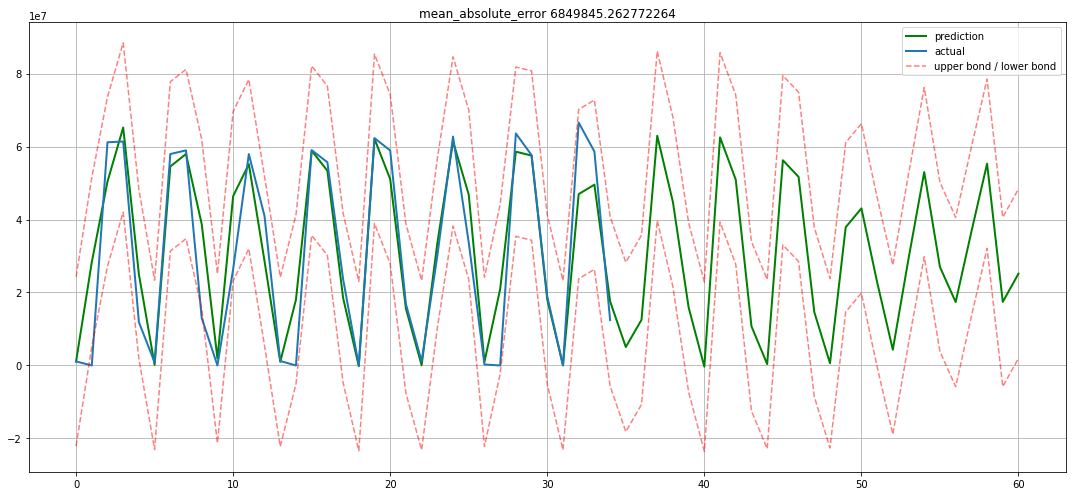

In [192]:
#5
train_align = AlignData(5)
model = XGBRegressor() 
#model = LinearRegression()
y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=8, model=model)
y_pred = y_pred[2:]
dfres5 = MergeVal(y_pred, 5)
#PosToZero(dfres5)

In [539]:
train_align = AlignData(5)
train_align = train_align[train_align.index.year > 2017]
train_align = train_align.iloc[5:]

In [540]:
lag_end=8
X_trainf, y_train, X_testf, y_test = prepareData(data=train_align,lag_start=1, lag_end=lag_end,test_size=0)

X_trainf['date'] = train_align.index[lag_end-1:]

In [421]:
def AddMissingVal(date1,c, r):
    feature1 = pd.DataFrame([[date1['date'+str(r)].values[0],date1['sum'+str(r)].values[0]]], columns=['date','feature'+str(c)])
    feature1=feature1.set_index('date')
    start_date = feature1.index[0]
    feature1 = feature1.reset_index()
    idx = 1
    while idx < 41:
        start_date = start_date + timedelta(days=7)
        if start_date == date1['date'+str(r)].values[idx]:
            feature1 = feature1.append(pd.DataFrame([[date1['date'+str(r)].values[idx],date1['sum'+str(r)].values[idx]]], columns=['date','feature'+str(c)]), ignore_index=True)
            idx +=1
        else:
            feature1 = feature1.append(pd.DataFrame([[start_date,0]], columns=['date','feature'+str(c)]), ignore_index=True)
    return feature1

In [504]:
feature1=AddMissingVal(data1w1add,1,1)
feature2=AddMissingVal(data1w2add,2,1)
feature3=AddMissingVal(data1w3add,3,1)
feature4=AddMissingVal(data2w2add,4,2)
feature5=AddMissingVal(data2w3add,5,2)

In [505]:
# find end index for train
feature1_add=feature1[151:]
feature2_add=feature2[150:]
feature3_add=feature3[149:]
feature4_add=feature4[150:]
feature5_add=feature5[149:]

In [506]:
feature1 = feature1.iloc[lag_end-2:151]
feature1 = feature1.set_index('date')
feature1 = feature1.reset_index()

In [507]:
feature2 = feature2.iloc[lag_end-3:150]
feature2 = feature2.set_index('date')
feature2 = feature2.reset_index()

In [508]:
feature3 = feature3.iloc[lag_end-4:149]
feature3 = feature3.set_index('date')
feature3 = feature3.reset_index()

In [509]:
feature4 = feature4.iloc[lag_end-3:150]
feature4 = feature4.set_index('date')
feature4 = feature4.reset_index()

In [510]:
feature5 = feature5.iloc[lag_end-4:149]
feature5 = feature5.set_index('date')
feature5 = feature5.reset_index()

In [518]:
# объединим все фитчи с лагами
frames = [feature1,feature2,feature3,feature4,feature5,X_trainf]
X_trainf = pd.concat(frames, axis=1)
X_trainf.drop(['date'], axis=1, inplace=True)

In [541]:
# объединим первую фитчу с лагами
frames = [feature1,X_trainf]
X_trainf = pd.concat(frames, axis=1)
X_trainf.drop(['date'], axis=1, inplace=True)

In [542]:
X_trainf

,feature1,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,0.000000e+00,5.288902e+07,5.325304e+07,0.000000e+00,1.794373e+07,5.302504e+07,5.143660e+07,2.201709e+06
1,0.000000e+00,1.004467e+07,5.288902e+07,5.325304e+07,0.000000e+00,1.794373e+07,5.302504e+07,5.143660e+07
2,4.281258e+07,0.000000e+00,1.004467e+07,5.288902e+07,5.325304e+07,0.000000e+00,1.794373e+07,5.302504e+07
3,0.000000e+00,5.147738e+07,0.000000e+00,1.004467e+07,5.288902e+07,5.325304e+07,0.000000e+00,1.794373e+07
4,0.000000e+00,5.667427e+07,5.147738e+07,0.000000e+00,1.004467e+07,5.288902e+07,5.325304e+07,0.000000e+00
...,...,...,...,...,...,...,...,...
140,0.000000e+00,1.890154e+07,5.764737e+07,6.357985e+07,0.000000e+00,2.663099e+05,3.369591e+07,6.273384e+07
141,5.463874e+07,0.000000e+00,1.890154e+07,5.764737e+07,6.357985e+07,0.000000e+00,2.663099e+05,3.369591e+07
142,0.000000e+00,6.657158e+07,0.000000e+00,1.890154e+07,5.764737e+07,6.357985e+07,0.000000e+00,2.663099e+05
143,0.000000e+00,5.862773e+07,6.657158e+07,0.000000e+00,1.890154e+07,5.764737e+07,6.357985e+07,0.000000e+00


In [521]:
# предсказания для всех фичей
lag_start=1
cntpred=23
X_train_scaled = scaler.fit_transform(X_trainf)

y1_pred = y_train[-1:]
y_pred = []
X_testf = pd.DataFrame(X_trainf[-1:].copy())    
for j in range(cntpred):
    for i in range(lag_end-2, lag_start-1,-1):
        X_testf.iloc[0,5+i]=X_testf.iloc[0,5+i-1]
    X_testf.iloc[0,5+0]=y1_pred
    # add new feature
    X_testf.iloc[0,0] = feature1_add['feature1'].values[j]
    X_testf.iloc[0,1] = feature2_add['feature2'].values[j]
    X_testf.iloc[0,2] = feature3_add['feature3'].values[j]
    X_testf.iloc[0,3] = feature4_add['feature4'].values[j]
    X_testf.iloc[0,4] = feature5_add['feature5'].values[j]
    
    X_test_scaled = scaler.transform(X_testf)
    model.fit(X_trainf, y_train)
    y1_pred = model.predict(X_testf)[0]
    y_pred.append(y1_pred)

# занулим значения
y_pred = np.array(y_pred)
y_pred[y_pred<0]=0

In [543]:
# предсказания для первой фичи
lag_start=1
cntpred=23
X_train_scaled = scaler.fit_transform(X_trainf)

y1_pred = y_train[-1:]
y_pred = []
X_testf = pd.DataFrame(X_trainf[-1:].copy())    
for j in range(cntpred):
    for i in range(lag_end-2, lag_start-1,-1):
        X_testf.iloc[0,1+i]=X_testf.iloc[0,1+i-1]
    X_testf.iloc[0,1+0]=y1_pred
    # add new feature
    X_testf.iloc[0,0] = feature1_add['feature1'].values[j]
    
    X_test_scaled = scaler.transform(X_testf)
    model.fit(X_trainf, y_train)
    y1_pred = model.predict(X_testf)[0]
    y_pred.append(y1_pred)

# занулим значения
y_pred = np.array(y_pred)
y_pred[y_pred<0]=0

In [546]:
y_pred = y_pred[3:]
dfres5f = MergeVal(y_pred, 5)

In [537]:
valid_res['Сумма в валюте транзакции'] = valid_res['Сумма в валюте транзакции'].apply(lambda x: x*-1)

In [530]:
def comparePredValPlot(title=''):
    res_buf = dfres5f
    res_buf=res_buf.set_index('date')
    res_buf.drop(['month','bu'], axis=1, inplace=True)
    
    res_bu = dfres5
    res_bu=res_bu.set_index('date')
    res_bu.drop(['month','bu'], axis=1, inplace=True)
    
    valid_res_bu = valid_res.loc[valid_res['БЕ']==5]
    valid_res_bu=valid_res_bu.rename(columns={valid_res_bu.columns[2]:'Дата'})
    valid_res_bu['Дата']=pd.to_datetime(valid_res_bu['Дата'])
    valid_res_bu=valid_res_bu.set_index('Дата')
    valid_res_bu.drop(['БЕ','Период'], axis=1, inplace=True)
    data = []
    
    train_align = AlignData(5)
    train_bu = train_align.iloc[-60:]
    #train_bu = train.loc[train['БЕ']==5]
    #train_bu = train_bu.iloc[-60:]
    #train_bu=train_bu.set_index('Дата транзакции')
    #train_bu.drop(['БЕ'], axis=1, inplace=True)
    
    title1 = {0:"predf",1:'pred',2:"valid",3:"train"}
    
    for idx,df in enumerate([res_buf,res_bu,valid_res_bu,train_bu]):
        for column in df.columns:
            trace = go.Scatter(
                x = df.index,
                y = df[column],
                mode = 'lines',
                name = title1[idx]
            )
            data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [547]:
comparePredValPlot()

In [550]:
def mae_monthly(X_df, y_df):
    y_df['Расчет ликвидности - дата'] = pd.to_datetime(y_df['Расчет ликвидности - дата'])
    y_df = y_df.rename({'Расчет ликвидности - дата': 'date', 'Сумма в валюте транзакции':'sum'}, axis=1)
    #y_df['cumsum'] = y_df.groupby(by=['Период'])['Сумма в валюте транзакции'].cumsum()
    
    #X_df['period'] = X_df['date'].dt.month
    #X_df['cumsum'] = X_df.groupby(by=['period'])['sum'].cumsum()
    
    merged_df = X_df[['date', 'sum']].merge(y_df[['date', 'sum']], on='date', how='outer').fillna(0).sort_values(by=['date'], ascending=True)
    merged_df['period'] = merged_df['date'].dt.month
    merged_df['x_cumsum'] = merged_df.groupby(by=['period'])['sum_x'].cumsum()
    merged_df['y_cumsum'] = merged_df.groupby(by=['period'])['sum_y'].cumsum()
    mae_list = []
    for i in range(1,max(merged_df['period']),1):
        filtered_merged_df = merged_df[merged_df['period']==i]
        mae_list.append(mean_absolute_error(filtered_merged_df['x_cumsum'], filtered_merged_df['y_cumsum']))
    return np.mean(mae_list)

mae_monthly(dfres5f.copy(), valid_res[valid_res['БЕ']==0].copy())

406944400.89704967